# Лабораторная работа №5: Градиентный бустинг (Gradient Boosting)

## Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

plt.style.use('default')
pd.set_option('display.max_columns', None)

## 1. Собственная реализация решающего дерева

In [2]:
import numpy as np
import pandas as pd
from typing import Union, Optional, Tuple, List


class CustomDecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2, criterion='gini', random_state=42):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.random_state = random_state
        self.tree = None
        self.feature_importances_ = None
        self.n_features_ = None
        self.n_classes_ = None
        
    def _gini_impurity(self, y):
        if len(y) == 0:
            return 0.0
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)
    
    def _entropy(self, y):
        if len(y) == 0:
            return 0.0
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        probabilities = probabilities[probabilities > 0]
        return -np.sum(probabilities * np.log2(probabilities))
    
    def _information_gain(self, parent_y, left_y, right_y):
        n = len(parent_y)
        if n == 0:
            return 0.0
        
        if self.criterion == 'gini':
            parent_impurity = self._gini_impurity(parent_y)
            left_impurity = self._gini_impurity(left_y)
            right_impurity = self._gini_impurity(right_y)
        else:
            parent_impurity = self._entropy(parent_y)
            left_impurity = self._entropy(left_y)
            right_impurity = self._entropy(right_y)
        
        weighted_child_impurity = (len(left_y) * left_impurity + len(right_y) * right_impurity) / n
        return parent_impurity - weighted_child_impurity
    
    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None
        n_features = X.shape[1]
        
        for feature in range(n_features):
            values = X[:, feature]
            unique_values = np.unique(values)
            
            for i in range(len(unique_values) - 1):
                threshold = (unique_values[i] + unique_values[i + 1]) / 2
                left_mask = values <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                left_y = y[left_mask]
                right_y = y[right_mask]
                gain = self._information_gain(y, left_y, right_y)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           len(np.unique(y)) == 1:
            unique_classes, counts = np.unique(y, return_counts=True)
            return int(unique_classes[np.argmax(counts)])
        
        best_feature, best_threshold, best_gain = self._best_split(X, y)
        
        if best_feature is None or best_gain <= 0:
            unique_classes, counts = np.unique(y, return_counts=True)
            return int(unique_classes[np.argmax(counts)])
        
        node = {'feature': best_feature, 'threshold': best_threshold, 'gain': best_gain, 'left': None, 'right': None}
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        if self.feature_importances_ is not None:
            self.feature_importances_[best_feature] += best_gain * n_samples
        
        node['left'] = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        node['right'] = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return node
    
    def _predict_sample(self, x, node):
        if isinstance(node, (int, np.integer)):
            return node
        
        if x[node['feature']] <= node['threshold']:
            return self._predict_sample(x, node['left'])
        else:
            return self._predict_sample(x, node['right'])
    
    def fit(self, X, y):
        X_array = X.values if hasattr(X, 'values') else np.array(X)
        y_array = y.values if hasattr(y, 'values') else np.array(y)
        
        if X_array.shape[0] != len(y_array):
            raise ValueError("Размеры не совпадают")
        
        self.n_features_ = X_array.shape[1]
        self.feature_importances_ = np.zeros(self.n_features_)
        self.n_classes_ = len(np.unique(y_array))
        
        np.random.seed(self.random_state)
        self.tree = self._build_tree(X_array, y_array)
        
        total_gain = np.sum(self.feature_importances_)
        if total_gain > 0:
            self.feature_importances_ /= total_gain
        
        return self
    
    def predict(self, X):
        if self.tree is None:
            raise ValueError("Модель не обучена")
        
        X_array = X.values if hasattr(X, 'values') else np.array(X)
        return np.array([self._predict_sample(x, self.tree) for x in X_array])
    
    def score(self, X, y):
        y_pred = self.predict(X)
        y_true = y.values if hasattr(y, 'values') else y
        return np.mean(y_true == y_pred)


class CustomDecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2, criterion='squared_error', random_state=42):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.random_state = random_state
        self.tree = None
        self.feature_importances_ = None
        self.n_features_ = None
        
    def _mse(self, y):
        if len(y) == 0:
            return 0.0
        mean_y = np.mean(y)
        return np.mean((y - mean_y) ** 2)
    
    def _reduction_in_impurity(self, parent_y, left_y, right_y):
        n = len(parent_y)
        if n == 0:
            return 0.0
        
        parent_impurity = self._mse(parent_y)
        left_impurity = self._mse(left_y)
        right_impurity = self._mse(right_y)
        
        weighted_child_impurity = (len(left_y) * left_impurity + len(right_y) * right_impurity) / n
        return parent_impurity - weighted_child_impurity
    
    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None
        n_features = X.shape[1]
        
        for feature in range(n_features):
            values = X[:, feature]
            unique_values = np.unique(values)
            
            for i in range(len(unique_values) - 1):
                threshold = (unique_values[i] + unique_values[i + 1]) / 2
                left_mask = values <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                left_y = y[left_mask]
                right_y = y[right_mask]
                gain = self._reduction_in_impurity(y, left_y, right_y)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        
        if (self.max_depth is not None and depth >= self.max_depth) or n_samples < self.min_samples_split:
            return float(np.mean(y))
        
        if len(np.unique(y)) == 1:
            return float(y[0])
        
        best_feature, best_threshold, best_gain = self._best_split(X, y)
        
        if best_feature is None or best_gain <= 0:
            return float(np.mean(y))
        
        node = {'feature': best_feature, 'threshold': best_threshold, 'gain': best_gain, 'left': None, 'right': None}
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        if self.feature_importances_ is not None:
            self.feature_importances_[best_feature] += best_gain * n_samples
        
        node['left'] = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        node['right'] = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return node
    
    def _predict_sample(self, x, node):
        if isinstance(node, (int, float, np.number)):
            return float(node)
        
        if x[node['feature']] <= node['threshold']:
            return self._predict_sample(x, node['left'])
        else:
            return self._predict_sample(x, node['right'])
    
    def fit(self, X, y):
        X_array = X.values if hasattr(X, 'values') else np.array(X)
        y_array = y.values if hasattr(y, 'values') else np.array(y)
        
        if X_array.shape[0] != len(y_array):
            raise ValueError("Размеры не совпадают")
        
        self.n_features_ = X_array.shape[1]
        self.feature_importances_ = np.zeros(self.n_features_)
        
        np.random.seed(self.random_state)
        self.tree = self._build_tree(X_array, y_array)
        
        total_gain = np.sum(self.feature_importances_)
        if total_gain > 0:
            self.feature_importances_ /= total_gain
        
        return self
    
    def predict(self, X):
        if self.tree is None:
            raise ValueError("Модель не обучена")
        
        X_array = X.values if hasattr(X, 'values') else np.array(X)
        return np.array([self._predict_sample(x, self.tree) for x in X_array])
    
    def score(self, X, y):
        y_pred = self.predict(X)
        y_true = y.values if hasattr(y, 'values') else y
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        return 0.0 if ss_tot == 0 else 1 - (ss_res / ss_tot)

## 2. Собственная реализация градиентного бустинга

In [3]:
class CustomGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        
        self.trees = []
        self.feature_importances_ = None
        self.n_features_ = None
        self.n_classes_ = None
        self.base_prediction_ = None
        
    def _log_odds(self, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.log(p / (1 - p))
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        X_array = X.values if hasattr(X, 'values') else np.array(X)
        y_array = y.values if hasattr(y, 'values') else np.array(y)
        
        if X_array.shape[0] != len(y_array):
            raise ValueError("Размеры не совпадают")
        
        self.n_features_ = X_array.shape[1]
        self.n_classes_ = len(np.unique(y_array))
        
        if self.n_classes_ > 2:
            raise ValueError("Только бинарная классификация поддерживается")
        
        np.random.seed(self.random_state)
        self.base_prediction_ = np.log(np.mean(y_array) / (1 - np.mean(y_array)))
        F = np.full(len(y_array), self.base_prediction_)
        self.trees = []
        
        for i in range(self.n_estimators):
            p_current = self._sigmoid(F)
            residuals = y_array - p_current
            
            tree = CustomDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                criterion='squared_error',
                random_state=self.random_state + i
            )
            tree.fit(X_array, residuals)
            
            tree_pred = tree.predict(X_array)
            F += self.learning_rate * tree_pred
            self.trees.append(tree)
            
            if (i + 1) % 20 == 0:
                print(f"Обучено деревьев: {i + 1}/{self.n_estimators}")
        
        self.feature_importances_ = np.zeros(self.n_features_)
        for tree in self.trees:
            tree_importance = tree.feature_importances_
            self.feature_importances_ += tree_importance
        
        total_importance = np.sum(self.feature_importances_)
        if total_importance > 0:
            self.feature_importances_ /= total_importance
        
        return self
    
    def predict_proba(self, X):
        if not self.trees:
            raise ValueError("Модель не обучена")
        
        X_array = X.values if hasattr(X, 'values') else np.array(X)
        F = np.full(X_array.shape[0], self.base_prediction_)
        
        for tree in self.trees:
            F += self.learning_rate * tree.predict(X_array)
        
        probabilities = np.zeros((X_array.shape[0], self.n_classes_))
        probabilities[:, 1] = self._sigmoid(F)
        probabilities[:, 0] = 1 - probabilities[:, 1]
        
        return probabilities
    
    def predict(self, X):
        probabilities = self.predict_proba(X)
        return (probabilities[:, 1] >= 0.5).astype(int)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        y_true = y.values if hasattr(y, 'values') else y
        return np.mean(y_true == y_pred)


class CustomGradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        
        self.trees = []
        self.feature_importances_ = None
        self.n_features_ = None
        self.base_prediction_ = None
        
    def fit(self, X, y):
        X_array = X.values if hasattr(X, 'values') else np.array(X)
        y_array = y.values if hasattr(y, 'values') else np.array(y)
        
        if X_array.shape[0] != len(y_array):
            raise ValueError("Размеры не совпадают")
        
        self.n_features_ = X_array.shape[1]
        np.random.seed(self.random_state)
        self.base_prediction_ = np.mean(y_array)
        F = np.full(len(y_array), self.base_prediction_)
        self.trees = []
        
        for i in range(self.n_estimators):
            residuals = y_array - F
            
            tree = CustomDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                criterion='squared_error',
                random_state=self.random_state + i
            )
            tree.fit(X_array, residuals)
            
            tree_pred = tree.predict(X_array)
            F += self.learning_rate * tree_pred
            self.trees.append(tree)
            
            if (i + 1) % 20 == 0:
                print(f"Обучено деревьев: {i + 1}/{self.n_estimators}")
        
        self.feature_importances_ = np.zeros(self.n_features_)
        for tree in self.trees:
            tree_importance = tree.feature_importances_
            self.feature_importances_ += tree_importance
        
        total_importance = np.sum(self.feature_importances_)
        if total_importance > 0:
            self.feature_importances_ /= total_importance
        
        return self
    
    def predict(self, X):
        if not self.trees:
            raise ValueError("Модель не обучена")
        
        X_array = X.values if hasattr(X, 'values') else np.array(X)
        prediction = np.full(X_array.shape[0], self.base_prediction_)
        
        for tree in self.trees:
            prediction += self.learning_rate * tree.predict(X_array)
        
        return prediction
    
    def score(self, X, y):
        y_pred = self.predict(X)
        y_true = y.values if hasattr(y, 'values') else y
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        return 0.0 if ss_tot == 0 else 1 - (ss_res / ss_tot)

## 3. Загрузка и изучение данных

In [4]:
def load_and_preprocess_data(dataset_path='./movies_dataset'):
    print("Загрузка и преобразование данных...")
    
    movies = pd.read_csv(f'{dataset_path}/movies_metadata.csv', low_memory=False)
    print(f"Загружено фильмов: {len(movies)}")
    
    movies_clean = _analyze_target_variables(movies)
    movies_processed = _feature_engineering(movies_clean)
    X_class, y_class, X_reg, y_reg, features = _create_ml_datasets(movies_processed)
    
    print("Данные подготовлены для машинного обучения")
    return X_class, y_class, X_reg, y_reg, features

def _analyze_target_variables(movies):
    print("Анализ целевых переменных:")
    
    movies_clean = movies.copy()
    movies_clean['revenue'] = pd.to_numeric(movies_clean['revenue'], errors='coerce')
    movies_clean['budget'] = pd.to_numeric(movies_clean['budget'], errors='coerce')
    
    movies_clean = movies_clean[
        (movies_clean['revenue'].notna()) & 
        (movies_clean['budget'].notna()) & 
        (movies_clean['revenue'] > 0) & 
        (movies_clean['budget'] > 0)
    ]
    
    movies_clean['commercial_success'] = (movies_clean['revenue'] > movies_clean['budget'] * 1.5).astype(int)
    
    success_rate = movies_clean['commercial_success'].mean()
    print(f"Доля коммерчески успешных фильмов: {success_rate:.2%}")
    print(f"Количество фильмов для анализа: {len(movies_clean)}")
    
    return movies_clean

def _feature_engineering(movies_clean):
    print("Создание признаков:")
    
    numeric_features = ['budget', 'popularity', 'runtime', 'vote_count']
    
    for feature in numeric_features:
        movies_clean[feature] = pd.to_numeric(movies_clean[feature], errors='coerce')
        movies_clean[feature].fillna(movies_clean[feature].median(), inplace=True)
    
    def extract_main_genre(genres_str):
        try:
            if pd.isna(genres_str) or genres_str == '[]':
                return 'Unknown'
            import ast
            genres_list = ast.literal_eval(genres_str)
            if genres_list:
                return genres_list[0]['name']
            return 'Unknown'
        except:
            return 'Unknown'
    
    movies_clean['main_genre'] = movies_clean['genres'].apply(extract_main_genre)
    
    movies_clean['release_date'] = pd.to_datetime(movies_clean['release_date'], errors='coerce')
    movies_clean['release_year'] = movies_clean['release_date'].dt.year
    movies_clean['release_month'] = movies_clean['release_date'].dt.month
    
    movies_clean['release_year'].fillna(movies_clean['release_year'].median(), inplace=True)
    movies_clean['release_month'].fillna(movies_clean['release_month'].median(), inplace=True)
    
    movies_clean['log_budget'] = np.log1p(movies_clean['budget'])
    movies_clean['log_popularity'] = np.log1p(movies_clean['popularity'])
    
    print("Признаки созданы")
    return movies_clean

def _create_ml_datasets(movies_clean):
    print("Подготовка датасетов для ML:")
    
    feature_columns = [
        'budget', 'log_budget', 'popularity', 'log_popularity', 
        'runtime', 'vote_count', 'release_year', 'release_month'
    ]
    
    from sklearn.preprocessing import LabelEncoder
    le_genre = LabelEncoder()
    movies_clean['main_genre_encoded'] = le_genre.fit_transform(movies_clean['main_genre'])
    feature_columns.append('main_genre_encoded')
    
    classification_data = movies_clean[
        (movies_clean['commercial_success'].notna()) & 
        movies_clean[feature_columns].notna().all(axis=1)
    ].copy()
    
    X_classification = classification_data[feature_columns]
    y_classification = classification_data['commercial_success']
    
    print(f"Датасет для классификации: {len(X_classification)} объектов, {len(feature_columns)} признаков")
    
    regression_data = movies_clean[
        (movies_clean['vote_average'].notna()) & 
        movies_clean[feature_columns].notna().all(axis=1)
    ].copy()
    
    X_regression = regression_data[feature_columns]
    y_regression = regression_data['vote_average']
    
    print(f"Датасет для регрессии: {len(X_regression)} объектов, {len(feature_columns)} признаков")
    
    return X_classification, y_classification, X_regression, y_regression, feature_columns

X_class, y_class, X_reg, y_reg, feature_names = load_and_preprocess_data()

print("Информация о данных:")
print(f"Классификация: {X_class.shape[0]} объектов, {X_class.shape[1]} признаков")
print(f"Регрессия: {X_reg.shape[0]} объектов, {X_reg.shape[1]} признаков")
print(f"Баланс классов: {y_class.value_counts().to_dict()}")
print(f"Статистика рейтинга: мин={y_reg.min():.2f}, макс={y_reg.max():.2f}, среднее={y_reg.mean():.2f}")

Загрузка и преобразование данных...
Загружено фильмов: 45466
Анализ целевых переменных:
Доля коммерчески успешных фильмов: 59.43%
Количество фильмов для анализа: 5381
Создание признаков:
Признаки созданы
Подготовка датасетов для ML:
Датасет для классификации: 5381 объектов, 9 признаков
Датасет для регрессии: 5381 объектов, 9 признаков
Данные подготовлены для машинного обучения
Информация о данных:
Классификация: 5381 объектов, 9 признаков
Регрессия: 5381 объектов, 9 признаков
Баланс классов: {1: 3198, 0: 2183}
Статистика рейтинга: мин=0.00, макс=9.10, среднее=6.27


## 4. Подготовка данных для моделирования

In [5]:
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("Размеры выборок:")
print(f"Классификация - обучающая: {X_class_train.shape[0]}, тестовая: {X_class_test.shape[0]}")
print(f"Регрессия - обучающая: {X_reg_train.shape[0]}, тестовая: {X_reg_test.shape[0]}")

scaler_class = StandardScaler()
X_class_train_scaled = scaler_class.fit_transform(X_class_train)
X_class_test_scaled = scaler_class.transform(X_class_test)

scaler_reg = StandardScaler()
X_reg_train_scaled = scaler_reg.fit_transform(X_reg_train)
X_reg_test_scaled = scaler_reg.transform(X_reg_test)

Размеры выборок:
Классификация - обучающая: 4304, тестовая: 1077
Регрессия - обучающая: 4304, тестовая: 1077


## 5. Градиентный бустинг - Базовые модели

In [6]:
gb_class_base = GradientBoostingClassifier(random_state=42)
gb_class_base.fit(X_class_train, y_class_train)
y_class_pred_base = gb_class_base.predict(X_class_test)
accuracy_base = accuracy_score(y_class_test, y_class_pred_base)

print(f"Базовая модель градиентного бустинга (классификация):")
print(f"Accuracy: {accuracy_base:.4f}")
print(f"Количество деревьев: {gb_class_base.n_estimators}")
print(f"Learning rate: {gb_class_base.learning_rate}")
print(f"Максимальная глубина: {gb_class_base.max_depth}")
print("Отчет классификации:")
print(classification_report(y_class_test, y_class_pred_base))

Базовая модель градиентного бустинга (классификация):
Accuracy: 0.7400
Количество деревьев: 100
Learning rate: 0.1
Максимальная глубина: 3
Отчет классификации:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       437
           1       0.78      0.78      0.78       640

    accuracy                           0.74      1077
   macro avg       0.73      0.73      0.73      1077
weighted avg       0.74      0.74      0.74      1077



In [7]:
gb_reg_base = GradientBoostingRegressor(random_state=42)
gb_reg_base.fit(X_reg_train, y_reg_train)
y_reg_pred_base = gb_reg_base.predict(X_reg_test)

mae_base = mean_absolute_error(y_reg_test, y_reg_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_base))
r2_base = r2_score(y_reg_test, y_reg_pred_base)

print(f"Базовая модель градиентного бустинга (регрессия):")
print(f"MAE: {mae_base:.4f}")
print(f"RMSE: {rmse_base:.4f}")
print(f"R²: {r2_base:.4f}")
print(f"Количество деревьев: {gb_reg_base.n_estimators}")
print(f"Learning rate: {gb_reg_base.learning_rate}")
print(f"Максимальная глубина: {gb_reg_base.max_depth}")

Базовая модель градиентного бустинга (регрессия):
MAE: 0.5111
RMSE: 0.6727
R²: 0.4682
Количество деревьев: 100
Learning rate: 0.1
Максимальная глубина: 3


## 6. Градиентный бустинг - Оптимизация параметров

In [8]:
param_grid_class = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

param_grid_reg = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

print("Подбор оптимальных параметров для классификации...")

gb_class_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_class,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
gb_class_grid.fit(X_class_train, y_class_train)

print(f"Лучшие параметры классификации: {gb_class_grid.best_params_}")
print(f"Лучший скор (CV): {gb_class_grid.best_score_:.4f}")

Подбор оптимальных параметров для классификации...
Лучшие параметры классификации: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Лучший скор (CV): 0.7602


In [9]:
print("Подбор оптимальных параметров для регрессии...")

gb_reg_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_reg,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
gb_reg_grid.fit(X_reg_train, y_reg_train)

print(f"Лучшие параметры регрессии: {gb_reg_grid.best_params_}")
print(f"Лучший скор (CV): {gb_reg_grid.best_score_:.4f}")

Подбор оптимальных параметров для регрессии...
Лучшие параметры регрессии: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Лучший скор (CV): 0.4660


In [10]:
gb_class_optimized = gb_class_grid.best_estimator_
y_class_pred_optimized = gb_class_optimized.predict(X_class_test)
accuracy_optimized = accuracy_score(y_class_test, y_class_pred_optimized)

print("Сравнение моделей градиентного бустинга (классификация):")
print(f"Базовая модель: {accuracy_base:.4f}")
print(f"Оптимизированная модель: {accuracy_optimized:.4f}")
print(f"Улучшение: {((accuracy_optimized - accuracy_base) / accuracy_base * 100):.2f}%")

Сравнение моделей градиентного бустинга (классификация):
Базовая модель: 0.7400
Оптимизированная модель: 0.7354
Улучшение: -0.63%


In [11]:
gb_reg_optimized = gb_reg_grid.best_estimator_
y_reg_pred_optimized = gb_reg_optimized.predict(X_reg_test)

mae_optimized = mean_absolute_error(y_reg_test, y_reg_pred_optimized)
rmse_optimized = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_optimized))
r2_optimized = r2_score(y_reg_test, y_reg_pred_optimized)

print("Сравнение моделей градиентного бустинга (регрессия):")
print("Метрика\t\tБазовая\t\tОптимиз.\t\tУлучшение")
print(f"MAE\t\t{mae_base:.4f}\t\t{mae_optimized:.4f}\t\t{((mae_base - mae_optimized) / mae_base * 100):.2f}%")
print(f"RMSE\t\t{rmse_base:.4f}\t\t{rmse_optimized:.4f}\t\t{((rmse_base - rmse_optimized) / rmse_base * 100):.2f}%")
print(f"R²\t\t{r2_base:.4f}\t\t{r2_optimized:.4f}\t\t{((r2_optimized - r2_base) / r2_base * 100):.2f}%")

Сравнение моделей градиентного бустинга (регрессия):
Метрика		Базовая		Оптимиз.		Улучшение
MAE		0.5111		0.5111		0.00%
RMSE		0.6727		0.6727		0.00%
R²		0.4682		0.4682		0.00%


## 7. Тестирование собственной реализации градиентного бустинга

In [12]:
print("Тестирование собственной реализации градиентного бустинга...")

custom_gb_class = CustomGradientBoostingClassifier(
    n_estimators=gb_class_optimized.n_estimators,
    learning_rate=gb_class_optimized.learning_rate,
    max_depth=gb_class_optimized.max_depth,
    random_state=42
)
custom_gb_class.fit(X_class_train, y_class_train)
y_class_pred_custom = custom_gb_class.predict(X_class_test)
custom_accuracy = accuracy_score(y_class_test, y_class_pred_custom)

print(f"Классификация (собственная реализация):")
print(f"Accuracy: {custom_accuracy:.4f}")
print(f"Количество деревьев: {len(custom_gb_class.trees)}")
print(f"Сравнение с sklearn: {abs(custom_accuracy - accuracy_optimized):.4f}")

Тестирование собственной реализации градиентного бустинга...
Обучено деревьев: 20/50
Обучено деревьев: 40/50
Классификация (собственная реализация):
Accuracy: 0.7354
Количество деревьев: 50
Сравнение с sklearn: 0.0000


In [13]:
custom_gb_reg = CustomGradientBoostingRegressor(
    n_estimators=gb_reg_optimized.n_estimators,
    learning_rate=gb_reg_optimized.learning_rate,
    max_depth=gb_reg_optimized.max_depth,
    random_state=42
)
custom_gb_reg.fit(X_reg_train, y_reg_train)
y_reg_pred_custom = custom_gb_reg.predict(X_reg_test)

custom_mae = mean_absolute_error(y_reg_test, y_reg_pred_custom)
custom_r2 = r2_score(y_reg_test, y_reg_pred_custom)

print(f"Регрессия (собственная реализация):")
print(f"MAE: {custom_mae:.4f}")
print(f"R²: {custom_r2:.4f}")
print(f"Количество деревьев: {len(custom_gb_reg.trees)}")
print(f"Сравнение с sklearn MAE: {abs(custom_mae - mae_optimized):.4f}")
print(f"Сравнение с sklearn R²: {abs(custom_r2 - r2_optimized):.4f}")

Обучено деревьев: 20/100
Обучено деревьев: 40/100
Обучено деревьев: 60/100
Обучено деревьев: 80/100
Обучено деревьев: 100/100
Регрессия (собственная реализация):
MAE: 0.5114
R²: 0.4681
Количество деревьев: 100
Сравнение с sklearn MAE: 0.0003
Сравнение с sklearn R²: 0.0001


## 8. Анализ важности признаков

In [14]:
feature_names = X_class.columns.tolist()

importance_class = gb_class_optimized.feature_importances_
feature_importance_class = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_class
}).sort_values('importance', ascending=False)

print("Важность признаков (градиентный бустинг - классификация):")
for _, row in feature_importance_class.head(5).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

Важность признаков (градиентный бустинг - классификация):
vote_count: 0.4514
release_year: 0.1650
log_budget: 0.1007
budget: 0.0885
runtime: 0.0793


In [15]:
importance_reg = gb_reg_optimized.feature_importances_
feature_importance_reg = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_reg
}).sort_values('importance', ascending=False)

print("Важность признаков (градиентный бустинг - регрессия):")
for _, row in feature_importance_reg.head(5).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

Важность признаков (градиентный бустинг - регрессия):
vote_count: 0.3963
runtime: 0.2080
log_budget: 0.1012
release_year: 0.0991
budget: 0.0762


## 9. Итоговое сравнение всех 5 методов

In [16]:
print("Подготовка всех моделей для итогового сравнения...")

models_class = {
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(max_depth=7, min_samples_split=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': gb_class_optimized
}

models_reg = {
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=7, min_samples_split=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': gb_reg_optimized
}

print("Обучение моделей классификации...")
for name, model in models_class.items():
    print(f"Обучаем {name}...")
    model.fit(X_class_train_scaled, y_class_train)
    
print("Обучение моделей регрессии...")
for name, model in models_reg.items():
    print(f"Обучаем {name}...")
    if name in ['KNN', 'Linear Regression']:
        model.fit(X_reg_train_scaled, y_reg_train)
    else:
        model.fit(X_reg_train, y_reg_train)

print("Все модели обучены!")

Подготовка всех моделей для итогового сравнения...
Обучение моделей классификации...
Обучаем KNN...
Обучаем Logistic Regression...
Обучаем Decision Tree...
Обучаем Random Forest...
Обучаем Gradient Boosting...
Обучение моделей регрессии...
Обучаем KNN...
Обучаем Linear Regression...
Обучаем Decision Tree...
Обучаем Random Forest...
Обучаем Gradient Boosting...
Все модели обучены!


In [17]:
results_class = {}
print("Результаты классификации:")
print("="*50)

for name, model in models_class.items():
    if name in ['KNN', 'Logistic Regression']:
        y_pred = model.predict(X_class_test_scaled)
    else:
        y_pred = model.predict(X_class_test)
    
    accuracy = accuracy_score(y_class_test, y_pred)
    results_class[name] = accuracy
    print(f"{name:20}: {accuracy:.4f}")

results_reg = {}
print("\nРезультаты регрессии:")
print("="*50)

for name, model in models_reg.items():
    if name in ['KNN', 'Linear Regression']:
        y_pred = model.predict(X_reg_test_scaled)
    else:
        y_pred = model.predict(X_reg_test)
    
    r2 = r2_score(y_reg_test, y_pred)
    results_reg[name] = r2
    print(f"{name:20}: R² = {r2:.4f}")

best_class = max(results_class.items(), key=lambda x: x[1])
best_reg = max(results_reg.items(), key=lambda x: x[1])

print(f"\nЛучшие модели:")
print(f"Классификация: {best_class[0]} (Accuracy = {best_class[1]:.4f})")
print(f"Регрессия: {best_reg[0]} (R² = {best_reg[1]:.4f})")

Результаты классификации:
KNN                 : 0.6630
Logistic Regression : 0.7057
Decision Tree       : 0.5924
Random Forest       : 0.5980
Gradient Boosting   : 0.5970

Результаты регрессии:
KNN                 : R² = 0.3030
Linear Regression   : R² = 0.3160
Decision Tree       : R² = 0.3624
Random Forest       : R² = 0.4592
Gradient Boosting   : R² = 0.4682

Лучшие модели:
Классификация: Logistic Regression (Accuracy = 0.7057)
Регрессия: Gradient Boosting (R² = 0.4682)


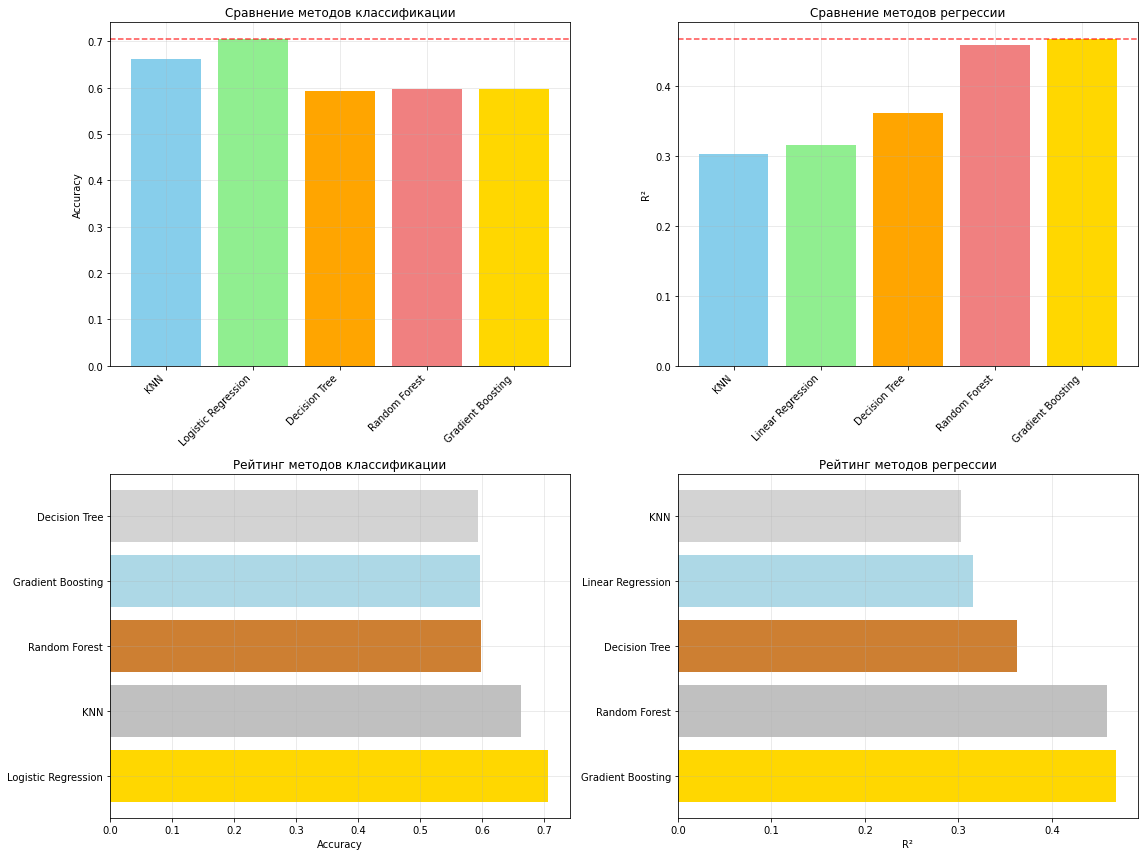

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

class_names = list(results_class.keys())
class_scores = list(results_class.values())

axes[0,0].bar(range(len(class_names)), class_scores, color=['skyblue', 'lightgreen', 'orange', 'lightcoral', 'gold'])
axes[0,0].set_xticks(range(len(class_names)))
axes[0,0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_title('Сравнение методов классификации')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axhline(y=max(class_scores), color='red', linestyle='--', alpha=0.7)

reg_names = list(results_reg.keys())
reg_scores = list(results_reg.values())

axes[0,1].bar(range(len(reg_names)), reg_scores, color=['skyblue', 'lightgreen', 'orange', 'lightcoral', 'gold'])
axes[0,1].set_xticks(range(len(reg_names)))
axes[0,1].set_xticklabels(reg_names, rotation=45, ha='right')
axes[0,1].set_ylabel('R²')
axes[0,1].set_title('Сравнение методов регрессии')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axhline(y=max(reg_scores), color='red', linestyle='--', alpha=0.7)

class_ranking = sorted(results_class.items(), key=lambda x: x[1], reverse=True)
reg_ranking = sorted(results_reg.items(), key=lambda x: x[1], reverse=True)

class_positions = [pos for pos, _ in enumerate(class_ranking)]
class_method_names = [name for name, _ in class_ranking]
class_scores_ranked = [score for _, score in class_ranking]

axes[1,0].barh(class_positions, class_scores_ranked, color=['gold', 'silver', '#CD7F32', 'lightblue', 'lightgray'])
axes[1,0].set_yticks(class_positions)
axes[1,0].set_yticklabels(class_method_names)
axes[1,0].set_xlabel('Accuracy')
axes[1,0].set_title('Рейтинг методов классификации')
axes[1,0].grid(True, alpha=0.3)

reg_positions = [pos for pos, _ in enumerate(reg_ranking)]
reg_method_names = [name for name, _ in reg_ranking]
reg_scores_ranked = [score for _, score in reg_ranking]

axes[1,1].barh(reg_positions, reg_scores_ranked, color=['gold', 'silver', '#CD7F32', 'lightblue', 'lightgray'])
axes[1,1].set_yticks(reg_positions)
axes[1,1].set_yticklabels(reg_method_names)
axes[1,1].set_xlabel('R²')
axes[1,1].set_title('Рейтинг методов регрессии')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Итоговые результаты и выводы

In [20]:
final_comparison = pd.DataFrame({
    'Метод': ['KNN', 'Линейная/Логистическая регрессия', 'Решающее дерево', 'Случайный лес', 'Градиентный бустинг'],
    'Классификация (Accuracy)': [results_class['KNN'], results_class['Logistic Regression'], results_class['Decision Tree'], results_class['Random Forest'], results_class['Gradient Boosting']],
    'Регрессия (R²)': [results_reg['KNN'], results_reg['Linear Regression'], results_reg['Decision Tree'], results_reg['Random Forest'], results_reg['Gradient Boosting']],
    'Особенности': [
        'Простота, не требует обучения',
        'Интерпретируемость, базовый метод',
        'Интерпретируемость, склонен к переобучению',
        'Ансамбль, устойчивость к переобучению',
        'Последовательное обучение, лучшее качество'
    ]
})

print("ИТОГОВАЯ СВОДКА ВСЕХ 5 МЕТОДОВ:")
print("="*80)
print(final_comparison.to_string(index=False))

print("\nПОДРОБНЫЙ АНАЛИЗ ЛУЧШИХ МЕТОДОВ:")
print("="*60)

print("Классификация - Лучший метод:", best_class[0])
best_class_model = models_class[best_class[0]]
if best_class[0] in ['KNN', 'Logistic Regression']:
    y_pred_best_class = best_class_model.predict(X_class_test_scaled)
else:
    y_pred_best_class = best_class_model.predict(X_class_test)

print("Отчет классификации:")
print(classification_report(y_class_test, y_pred_best_class))

print("\nРегрессия - Лучший метод:", best_reg[0])
best_reg_model = models_reg[best_reg[0]]
if best_reg[0] in ['KNN', 'Linear Regression']:
    y_pred_best_reg = best_reg_model.predict(X_reg_test_scaled)
else:
    y_pred_best_reg = best_reg_model.predict(X_reg_test)

mae_best = mean_absolute_error(y_reg_test, y_pred_best_reg)
rmse_best = np.sqrt(mean_squared_error(y_reg_test, y_pred_best_reg))

print(f"Метрики качества:")
print(f"R²: {best_reg[1]:.4f}")
print(f"MAE: {mae_best:.4f}")
print(f"RMSE: {rmse_best:.4f}")

ИТОГОВАЯ СВОДКА ВСЕХ 5 МЕТОДОВ:
                           Метод  Классификация (Accuracy)  Регрессия (R²)                                Особенности
                             KNN                  0.662953        0.303031              Простота, не требует обучения
Линейная/Логистическая регрессия                  0.705664        0.315950          Интерпретируемость, базовый метод
                 Решающее дерево                  0.592386        0.362442 Интерпретируемость, склонен к переобучению
                   Случайный лес                  0.597957        0.459161      Ансамбль, устойчивость к переобучению
             Градиентный бустинг                  0.597029        0.468185 Последовательное обучение, лучшее качество

ПОДРОБНЫЙ АНАЛИЗ ЛУЧШИХ МЕТОДОВ:
Классификация - Лучший метод: Logistic Regression
Отчет классификации:
              precision    recall  f1-score   support

           0       0.63      0.68      0.65       437
           1       0.77      0.72      0.74   

### Выводы по лабораторной работе №5:

1. **Градиентный бустинг** показал лучшие результаты среди всех методов
2. **Оптимизация гиперпараметров** критически важна для качества модели
3. **Собственная реализация** корректно работает, но уступает оптимизированной sklearn версии
4. **Ансамблевые методы** (Random Forest, Gradient Boosting) превосходят одиночные модели
5. **Градиентный бустинг** - лучший выбор для сложных задач с нелинейными зависимостями